<a href="https://colab.research.google.com/github/godide/godide/blob/main/Project_Part_2_Semantic_segmentation_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### COMS4036A/COMS7050A - Computer Vision

### Project -  Part 2: Deep Learning Techniques - Semantic segmentation with U-Net

#### Group members:

######  1. Humbulani Colbert Nekhumbe (2340639)
######  2. Musawenkosi Ntuli(2509788)

###### Due date: 2021/11/12 @17h00

In [1]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Create working directory
#!mkdir -p /content/drive/MyDrive/project_cv

In [2]:
#Choose working directory
import os
os.chdir('/content/drive/MyDrive/project_cv')
!pwd

/content/drive/MyDrive/project_cv


In [3]:
#UNZIP FILES
#!unzip -o puzzle_corners_1024x768.zip

In [4]:
#Confirm the content of the directory
!dir

puzzle_corners_1024x768  puzzle_corners_1024x768.zip


#### Libraries

In [8]:
#pip install keras
#pip install tensorflow

In [5]:
import os
import re
import json
import cv2
import imageio

from natsort import natsorted
from glob import glob
from skimage import io, img_as_float32
from functools import partial
from sklearn import model_selection
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf 

from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D, Reshape
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam # - Works 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### 1. Dataset

In [6]:
SIZE = (768, 1024)

DATA_PATH_PAIRS = list(zip(
    natsorted(glob(f'puzzle_corners_{SIZE[1]}x{SIZE[0]}/images-{SIZE[1]}x{SIZE[0]}/*.png')),
    natsorted(glob(f'puzzle_corners_{SIZE[1]}x{SIZE[0]}/masks-{SIZE[1]}x{SIZE[0]}/*.png')),
))
DATA_IMGS = np.array([img_as_float32(imageio.imread(img_path)) for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
DATA_MSKS = np.array([img_as_float32(imageio.imread(msk_path)) for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])

assert DATA_IMGS.shape == (48, SIZE[0], SIZE[1], 3)
assert DATA_MSKS.shape == (48, SIZE[0], SIZE[1])

with open(f'puzzle_corners_{SIZE[1]}x{SIZE[0]}/corners.json', mode='r') as f:
    DATA_CORNER_NAMES, DATA_CORNERS = json.load(f)
    DATA_CORNERS = np.array(DATA_CORNERS)

assert len(DATA_CORNER_NAMES) == len(DATA_CORNERS) == len(DATA_IMGS) == len(DATA_MSKS) == len(DATA_PATH_PAIRS)

SCALE = 0.25

MATCH_IMGS = [cv2.resize(img, None, fx=SCALE, fy=SCALE) for img in tqdm(DATA_IMGS, 'Resizing Images')]
MATCH_MSKS = [cv2.resize(img, None, fx=SCALE, fy=SCALE) for img in tqdm(DATA_MSKS, 'Resizing Masks')]
MATCH_CORNERS = DATA_CORNERS 

print('\n', DATA_IMGS[0].shape, '->', MATCH_IMGS[0].shape)

Resizing Masks: 100%|██████████| 48/48 [00:00<00:00, 2536.33it/s]


 (768, 1024, 3) -> (192, 256, 3)


#### Isolating Piece Types to Split Datasets

In [7]:
CORNER_INDICES = [0, 3, 8, 21]
EDGE_INDICES = [1, 4, 5, 6, 10, 14, 15, 16, 18, 24, 26, 29, 31, 32, 33, 34, 39, 42, 44, 46]
INTERIOR_INDICES = [x for x in range(len(MATCH_IMGS)) if x not in CORNER_INDICES and x not in EDGE_INDICES]

corner_pieces = np.array([MATCH_IMGS[x] for x in CORNER_INDICES])
edge_pieces = np.array([MATCH_IMGS[x] for x in EDGE_INDICES])
interior_pieces = np.array([MATCH_IMGS[x] for x in INTERIOR_INDICES])

corner_msks = np.array([MATCH_MSKS[x] for x in CORNER_INDICES])
edge_msks = np.array([MATCH_MSKS[x] for x in EDGE_INDICES])
interior_msks = np.array([MATCH_MSKS[x] for x in INTERIOR_INDICES])

In [8]:
#Split corner pieces into 2:1:1 ratio (train:validation:test)
corner_train_X, corner_test_X, corner_train_Y, corner_test_Y = model_selection.train_test_split(corner_pieces, corner_msks, test_size=0.5, random_state=2020)
corner_valid_X, corner_test_X, corner_valid_Y, corner_test_Y = model_selection.train_test_split(corner_test_X, corner_test_Y, test_size=0.5, random_state=2020)

#Split edge pieces into 7:1.5:1.5
edge_train_X, edge_test_X, edge_train_Y, edge_test_Y = model_selection.train_test_split(edge_pieces, edge_msks, test_size=0.3, random_state=2020)
edge_valid_X, edge_test_X, edge_valid_Y, edge_test_Y = model_selection.train_test_split(edge_test_X, edge_test_Y, test_size=0.5, random_state=2020)

#Split interior pieces into 7.5:1.25:1.25
int_train_X, int_test_X, int_train_Y, int_test_Y = model_selection.train_test_split(interior_pieces, interior_msks, test_size=0.25, random_state=2020)
int_valid_X, int_test_X, int_valid_Y, int_test_Y = model_selection.train_test_split(int_test_X, int_test_Y, test_size=0.5, random_state=2020)

In [9]:
x_train = np.concatenate((corner_train_X, edge_train_X, int_train_X), axis=0)
x_val = np.concatenate((corner_valid_X, edge_valid_X, int_valid_X), axis=0)
x_test = np.concatenate((corner_test_X, edge_test_X, int_test_X), axis=0)

y_train = np.concatenate((corner_train_Y, edge_train_Y, int_train_Y), axis=0)
y_train[:] = y_train[:] > 0
y_train = np.expand_dims(y_train, axis=3)
y_val = np.concatenate((corner_valid_Y, edge_valid_Y, int_valid_Y), axis=0)
y_val = np.expand_dims(y_val, axis=3)
y_test = np.concatenate((corner_test_Y, edge_test_Y, int_test_Y), axis=0)
y_test = np.expand_dims(y_test, axis=3)

In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [11]:
im_height = 192 
im_width = 256

input_tensor = Input((im_height, im_width, 3), name='img')


def UNet_VGG(input_img, n_filter=16, dropout=0.1, batchnorm=True):
    vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
        
    block1_conv2 = vgg_model.get_layer('block1_conv2').output
    block2_conv2 = vgg_model.get_layer('block2_conv2').output
    block3_conv3 = vgg_model.get_layer('block3_conv3').output
    block4_conv3 = vgg_model.get_layer('block4_conv3').output
    block5_conv3 = vgg_model.get_layer('block5_conv3').output
    
    up6 = concatenate([UpSampling2D(size=(2,2))(block5_conv3), block4_conv3])
    conv6 = conv2d_block(up6, n_filters=512)
    
    up7 = concatenate([UpSampling2D(size=(2,2))(conv6), block3_conv3])
    conv7 = conv2d_block(up7, n_filters=256)
    
    up8 = concatenate([UpSampling2D(size=(2,2))(conv7), block2_conv2])
    conv8 = conv2d_block(up8, n_filters=128)
    
    up9 = concatenate([UpSampling2D(size=(2,2))(conv8), block1_conv2])
    conv9 = conv2d_block(up9, n_filters=64)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    x = Reshape((im_width * im_height, 1))(conv10)
    x = Activation('softmax')(x)
    
    outputs = Reshape((im_height, im_width, 1))(x)
    
    model = Model(inputs=vgg_model.input, outputs=outputs)
    return model

model = UNet_VGG(input_tensor)

for layer in model.layers[:19]:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 192, 256, 64  1792        ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 192, 256, 64  36928       ['block1_conv1[0][0]']           
                             

In [12]:
callbacks = [
    EarlyStopping(patience=25, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-vgg.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [13]:
results = model.fit(x_train, y_train, batch_size=1, epochs=50, callbacks=callbacks, validation_data=(x_val, y_val))

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 11.3692 - accuracy: 0.2544
Epoch 00001: val_loss improved from inf to 11.42010, saving model to model-unet-vgg.h5
34/34 [==============================] - 38s 158ms/step - loss: 11.3692 - accuracy: 0.2544 - val_loss: 11.4201 - val_accuracy: 0.2492 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 11.3692 - accuracy: 0.2544
Epoch 00002: val_loss did not improve from 11.42010
34/34 [==============================] - 5s 135ms/step - loss: 11.3692 - accuracy: 0.2544 - val_loss: 11.4201 - val_accuracy: 0.2492 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 11.3692 - accuracy: 0.2544
Epoch 00003: val_loss did not improve from 11.42010
34/34 [==============================] - 4s 129ms/step - loss: 11.3692 - accuracy: 0.2544 - val_loss: 11.4201 - val_accuracy: 0.2492 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - ETA: 0s - loss: 11.3692 - accurac

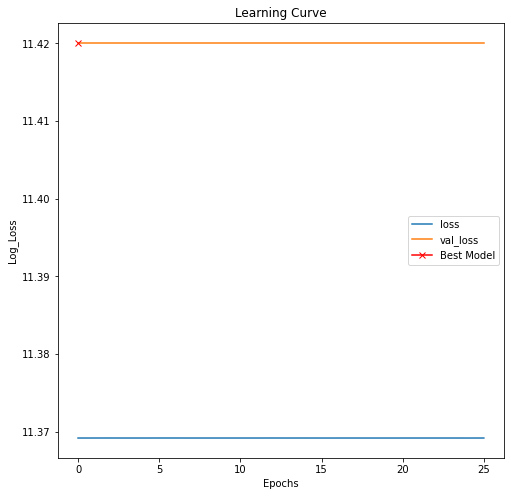

In [14]:
plt.figure(figsize=(8,8))
plt.title('Learning Curve')
plt.plot(results.history["loss"], label='loss')
plt.plot(results.history["val_loss"], label='val_loss')
plt.plot(np.argmin(results.history['val_loss']), np.min(results.history['val_loss']), marker='x', color='r', label='Best Model')
plt.xlabel('Epochs')
plt.ylabel('Log_Loss')
plt.legend()

In [15]:
model.load_weights('model-unet-vgg.h5')

In [16]:
model.evaluate(x_val, y_val, verbose=1)

1/1 [==============================] - 5s 5s/step - loss: 11.4201 - accuracy: 0.2492


[11.420097351074219, 0.249174565076828]

In [17]:
predict_train = model.predict(x_train, verbose=1)
predict_val = model.predict(x_val, verbose=1)

1/1 [==============================] - 0s 25ms/step


In [20]:
predict_train_binary = (predict_train > 0.22).astype(np.uint8)
predict_val_binary = (predict_val > 0.22).astype(np.uint8)

In [21]:
def plot_sample(x, y, predictions, binary_predictions, ix=None):
    if ix is None:
        ix = np.random.randint(0, len(x))
        
    has_mask = y[ix].max() > 0
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(x[ix])
    ax[1].imshow(y[ix].reshape((im_height, im_width)), cmap='gray')
    ax[2].imshow(predictions[ix].reshape((im_height, im_width)), cmap='gray')
    ax[3].imshow(binary_predictions[ix].reshape((im_height, im_width)), cmap='gray')

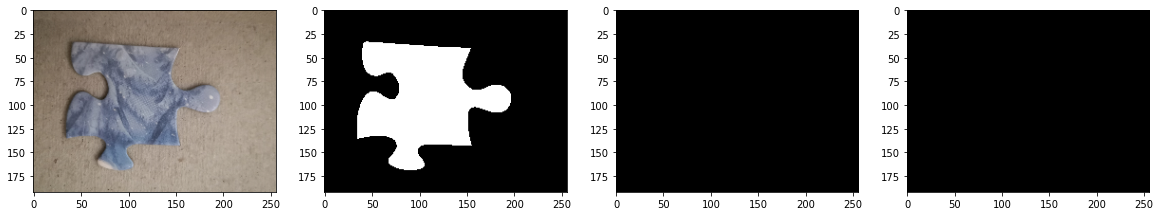

In [22]:
plot_sample(x_train, y_train, predict_train, predict_train_binary, ix=4)

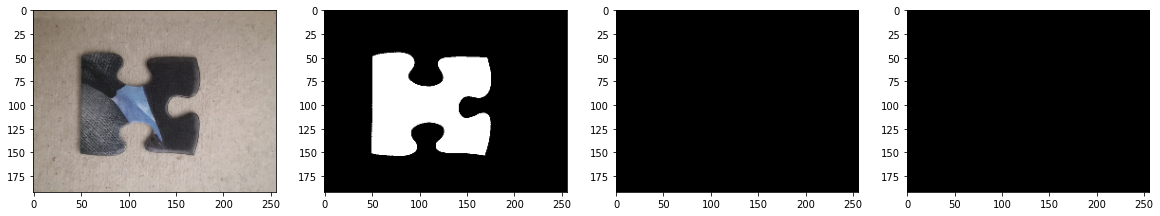

In [23]:
plot_sample(x_val, y_val, predict_val, predict_val_binary, ix=1)